In [110]:
"""
01/10/2021 added moisture flag, made it faster to run

09/26/2019 Model is stable!!

07/20/2010 Added LH03-type moisture, including omega-equation


"""
import numpy as np
import matplotlib.pylab as plt

import random
random.seed(100)
from random import random

import time

# from mpi4py_fft import fftw
import scipy.fft as sci_fft
#%matplotlib inline

#import os
#exec(open(os.environ['PYTHONSTARTUP']).read())
#exec(open(STARTUP_2020_moist_two_layer).read())
#xr.set_options(display_width=80, display_style='text')
#save_path =  mconfig['paths']['work']+'/experiments/optimzed_QG_N128_benchmark_scipy_workers/'
#MT.mkdirs_r(save_path)


#######################################################
#  Declare some parameters, arrays, etc.

opt = 3 # 1 = just the linear parts, 2 = just the nonlinear parts, 3 = full model

N = 64#128 #zonal size of spectral decomposition
N2 = 64#128 #meridional size of spectral decomposition
Lx = 72. #size of x -- stick to multiples of 10
Ly = 96. #size of y -- stick to multiples of 10


nu = pow( 10., -3. ) #viscous dissipation
tau_d = 100. #Newtonian relaxation time-scale for interface
tau_f = 15. #surface friction
beta = 0.196 #beta
sigma = 3.5
U_1 = 1.

g = 0.04 #leapfrog filter coefficient

moist = True
if moist:
	C = 2. #linearized Clausius-Clapeyron parameter
	L = 0.#3 #non-dimensional measure of the strength of latent heating
	E = 1. #Evaporation rate
	Gamma = beta - (1. + C * L) / (1. - L)
else:
	L=0.
	C =0.

count = 0 #for saving
d1 = 0 #for saving

x = np.linspace( -Lx / 2, Lx / 2, N )
y = np.linspace( -Ly / 2, Ly / 2, N2 )
dx= min([ np.diff(x)[0], np.diff(y)[0] ])#*110/700 # non-dimensional dx

#Wavenumbers:
kk = np.fft.rfftfreq( N, Lx / float(N) / 2. / np.pi ) #zonal wavenumbers
ll = np.fft.fftfreq( N2, Ly / float(N2) / 2. / np.pi ) #meridional wavenumbers

Lapl = -(np.expand_dims(ll, 1) ** 2 + np.expand_dims(kk, 0) ** 2)

tot_time = 1000  #00 #Length of run
dt 		 = 0.025 #Timestep
ts 		 = int(tot_time / dt ) #Total timesteps
lim  	 = int(300 // dt ) #int(ts / 4 ) #Start saving
st = int( 1 / dt ) #How often to save ../../data/moist_qg

fft = sci_fft # np.fft
nworker =10

#######################################################
#  Declare arrays

#Spectral arrays, only need 3 time-steps
psic_1 = np.zeros( ( ( 3 , N2 , N // 2 + 1 ) ) ).astype( complex )
psic_2 = np.zeros( ( ( 3 , N2 , N // 2 + 1 ) ) ).astype( complex )
qc_1 = np.zeros( ( ( 3 , N2, N // 2 + 1 ) ) ).astype( complex )
qc_2 = np.zeros( ( ( 3 , N2 , N // 2 + 1 ) ) ).astype( complex )
vorc_1 = np.zeros( ( ( 3 , N2, N // 2 + 1  ) ) ).astype( complex )
vorc_2 = np.zeros( ( ( 3 , N2 , N // 2 + 1 ) ) ).astype( complex )

print('comples spectral array shapes: ' + str(psic_1.shape))

# moisture variables
if moist:
	mc = np.zeros( ( ( 3, N2, N // 2 + 1 ) ) ).astype( complex ) #moisture
	M = np.zeros( 3 ) #Total moisture


#Real arrays, only need 3 time-steps
psi_1 = np.zeros( ( ( 3 , N2 , N ) ) )
psi_2 = np.zeros( ( ( 3 , N2 , N ) ) )
q_1 = np.zeros( ( ( 3 , N2, N ) ) )
q_2 = np.zeros( ( ( 3 , N2 , N ) ) )

print('real array shapes: ' + str(psi_1.shape))

#For saving:
u = np.zeros( ( ( int((ts - lim) / st) + 1, 2, N2 ) ) )
v = np.zeros( ( ( int((ts - lim) / st) + 1, 2, N2 ) ) )
tau = np.zeros( ( ( int((ts - lim) / st) + 1, 2, N2 ) ) )
precip = np.zeros( ( ( int((ts - lim) / st) + 1, 2, N2 ) ) )

CFL_store = np.zeros( ( ( int((ts - lim) / st) + 1 ) ) )
# z_emf = np.zeros( ( ( int((ts - lim) / st) + 1, 2, N2 ) ) )
# z_ehf = np.zeros( ( ( int((ts - lim) / st) + 1, 2, N2 ) ) )
# z_eke = np.zeros( ( ( int((ts - lim) / st) + 1, 2, N2 ) ) )

#######################################################
#  Define equilibrium interface height + sponge

sponge = np.zeros( N2)
u_eq = np.zeros( N2)

for i in range( N2 ):
	y1 = float( i - N2 /2) * (y[1] - y[0] )
	y2 = float(min(i, N2 -i - 1)) * (y[1] - y[0] )
	sponge[i] = U_1 / (np.cosh(abs(y2/sigma)))**2
	u_eq[i] = U_1 * ( 1. / (np.cosh(abs(y1/sigma)))**2 - 1. / (np.cosh(abs(y2/sigma)))**2  )

psi_Rc = -fft.fft(  u_eq ) / 1.j / ll
psi_Rc[0] = 0.
psi_R = fft.ifft(psi_Rc )

#plt.plot(psi_R)
#######################################################
# %% Spectral functions

comples spectral array shapes: (3, 64, 33)
real array shapes: (3, 64, 64)


/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


In [111]:
def ptq(l,k, ps1, ps2):

	"""
	Calculate PV
	in:
	meridional wavemnumber l, zonal wavenumber k, psi1(l,k), psi2(l,k)
	"""
	q1 = -(np.expand_dims(l, 1) ** 2 + np.expand_dims(k, 0) ** 2 ) * ps1 - (ps1 - ps2) # -(k^2 + l^2) * psi_1 -0.5*(psi_1-psi_2)
	q2 = -(np.expand_dims(l, 1) ** 2 + np.expand_dims(k, 0) ** 2 ) * ps2 + (ps1 - ps2) # -(k^2 + l^2) * psi_2 +0.5*(psi_1-psi_2)
	return q1, q2


def qtp(kk, ll, q1_s, q2_s):
	"""Invert PV"""
	divider =  ( np.expand_dims(ll, 1) ** 2 + np.expand_dims(kk, 0) ** 2)  # (psi_1 + psi_2)/2
	divider[0, 0] = np.nan
	psi_bt = -(q1_s + q2_s) / divider / 2.0  # (psi_1 + psi_2)/2
	psi_bt[0, 0] = 0.

	psi_bc = -(q1_s - q2_s) / (np.expand_dims(ll, 1) ** 2 + np.expand_dims(kk, 0) ** 2 + 2. ) / 2.  # (psi_1 - psi_2)/2

	psi1 = psi_bt + psi_bc
	psi2 = psi_bt - psi_bc

	return psi1, psi2


def qtp_3d(kk, ll, q1_s, q2_s):
	"""Invert PV"""

	divider =  ( np.expand_dims(ll, 1) ** 2 + np.expand_dims(kk, 0) ** 2)  # (psi_1 + psi_2)/2
	divider[0, 0] = np.nan
	psi_bt = -(q1_s + q2_s) / divider  /2.0 # (psi_1 + psi_2)/2
	psi_bt[:, 0, 0] = 0.

	psi_bc = -(q1_s - q2_s) / (np.expand_dims(ll, 1) ** 2 + np.expand_dims(kk, 0) ** 2 + 2. ) / 2.  # (psi_1 - psi_2)/2

	psi1 = psi_bt + psi_bc
	psi2 = psi_bt - psi_bc

	return psi1, psi2


def exponential_cutoff( data, a, s, kcut ):
    d1, d2 = np.shape( data )
    F = np.ones( ( d1, d2 ) )
    for i in range( d1 ):
        for j in range( d2 ):
            if i > 9 and i <= d1 / 2:
                F[i, j] *= np.exp( -a * ((float(i - kcut)/float(d1 / 2 - 1 - kcut) )) ** s )
            elif i > d1 / 2 and i < (d1 - 10 ):
                k = d1 - i
                F[i, j] *= np.exp( -a * ((float(k - kcut)/float(d1 / 2 - 1 - kcut) )) ** s )
            if j > 9:
                F[i, j] *= np.exp( -a * ((float(j - kcut)/float(d2 - 1 - kcut) )) ** s )
    return F

def sdat(c, F):
    print("Saving in:", F)
    np.savez(F,u = c)
    return 0

#ll_ax1= np.expand_dims(ll, 1)
#kk_ax0= np.expand_dims(kk, 0)
def div( field, kk, ll ): # former grad()

	d1, d2 = np.shape( field )
	div = np.zeros( ( d1, d2 ) ) + 0.j
	div[:, :] = 1.j * np.expand_dims(ll, 1) + 1.j * np.expand_dims(kk, 0)

	return div * field

def Laplace( field, kk, ll ):

	d1, d2 = np.shape( field )
	Lapl = np.zeros( ( d1, d2 ) )
	Lapl[:, :] = -(np.expand_dims(ll, 1) ** 2 + np.expand_dims(kk, 0) ** 2)

	return Lapl * field



#######################################################
#  Time-stepping functions

# %%
def reshuffle_helper1(psi, qc):

	N2, N = np.shape( psi )
	ex = int(N *  3 / 2)# - 1
	ex2 = int(N2 * 3 / 2)# - 1
	temp1 = np.zeros( ( ex2, ex ) ) + 0.j
	temp2 = np.zeros( ( ex2, ex ) ) + 0.j
	temp4 = np.zeros( ( N2, N ) ) + 0.j	#Final array

	#Pad values:
	temp1[:N2//2, :N] = psi[:N2//2, :N]
	temp1[ex2-N2//2:, :N] = psi[N2//2:, :N]

	temp2[:N2//2, :N] = qc[:N2//2, :N]
	temp2[ex2-N2//2:, :N] = qc[N2//2:, :N]
	return temp1, temp2, temp4, N2, N, ex2

def reshuffle_helper2(temp3, temp4, N2, N, ex2 ):

	temp4[:N2//2, :N] = temp3[:N2//2, :N]
	temp4[N2//2:, :N] = temp3[ex2-N2//2:, :N]
	return temp4

def calc_nl( psi, qc ):
	""""Calculate non-linear terms, with Orszag 3/2 de-aliasing"""

	# N2, N = np.shape( psi )
	# ex = int(N *  3 / 2)# - 1
	# ex2 = int(N2 * 3 / 2)# - 1
	# temp1 = np.zeros( ( ex2, ex ) ) + 0.j
	# temp2 = np.zeros( ( ex2, ex ) ) + 0.j
	# temp4 = np.zeros( ( N2, N ) ) + 0.j	#Final array
	#
	# #Pad values:
	# temp1[:N2//2, :N] = psi[:N2//2, :N]
	# temp1[ex2-N2//2:, :N] = psi[N2//2:, :N]
	#
	# temp2[:N2//2, :N] = qc[:N2//2, :N]
	# temp2[ex2-N2//2:, :N] = qc[N2//2:, :N]

	temp1, temp2, temp4 , N2, N, ex2 = reshuffle_helper1(psi, qc)
	#Fourier transform product, normalize, and filter:
	temp3 = fft.rfft2( fft.irfft2( temp1 , workers=nworker ) * fft.irfft2( temp2, workers=nworker ) , workers=nworker ) * 9. / 4.
	# temp4[:N2//2, :N] = temp3[:N2//2, :N]
	# temp4[N2//2:, :N] = temp3[ex2-N2//2:, :N]

	return reshuffle_helper2(temp3, temp4, N2, N, ex2)

def jacobian_prep(kk, ll, psi, qc):
    kk2, ll2 =np.expand_dims(kk, 0), np.expand_dims(ll, 1)
    dpsi_dx = 1.j * kk2 * psi
    dpsi_dy = 1.j * ll2 * psi

    dq_dx = 1.j * kk2 * qc
    dq_dy = 1.j * ll2 * qc
    return dpsi_dx, dq_dy, dpsi_dy ,dq_dx

def nlterm(kk, ll, psi, qc):
    """"Calculate Jacobian"""
    dpsi_dx, dq_dy, dpsi_dy ,dq_dx = jacobian_prep(kk, ll, psi, qc)  ######### here was an error
    return  calc_nl( dpsi_dx, dq_dy ) - calc_nl( dpsi_dy, dq_dx )


def fs(ovar, rhs, det, nu, kk, ll):
    """Forward Step: q^t-1 / ( 1 + 2. dt * nu * (k^4 + l^4 ) ) + RHS"""
    mult = det / ( 1. + det * nu * (np.expand_dims(kk, 0) ** 4 + np.expand_dims(ll, 1) ** 4) )

    return mult * (ovar / det + rhs)


def lf(oovar, rhs, det, nu, kk, ll):
    """Leap frog timestepping: q^t-2 / ( 1 + 2. * dt * nu * (k^4 + l^4 ) ) + RHS"""
    mult = 2. * det / ( 1. + 2. * det * nu * (np.expand_dims(kk, 0) ** 4 + np.expand_dims(ll, 1) ** 4) )
    return mult * (oovar / det / 2. + rhs)

def filt(var, ovar, nvar, g):
	"""Leapfrog filtering"""
	return var + g * (ovar - 2. * var + nvar )



In [112]:
#######################################################
# %% Initial conditions:

psic_1[0] = [ [ random() for i in range(N // 2 + 1 ) ] for j in range(N2) ] # wn space
psic_2[0] = [ [ random() for i in range(N // 2 + 1 ) ] for j in range(N2) ]

#Transfer values:
psic_1[ 1 , : , : ] = psic_1[ 0 , : , : ]
psic_2[ 1 , : , : ] = psic_2[ 0 , : , : ]

#Calculate initial PV
# %%

for i in range( 2 ):
	vorc_1[i], vorc_2[i] = ptq(ll, kk, psic_1[i], psic_2[i]) # in and outputs in wave number space

q_1[0:2, :,: ] = fft.irfft2( vorc_1[0:2,:,:], workers=nworker ) + beta * y[:, np.newaxis] # to real
q_2[0:2, :,: ] = fft.irfft2( vorc_2[0:2,:,:], workers=nworker ) + beta * y[:, np.newaxis] # to real

qc_1[0:2,:,:] = fft.rfft2( q_1[0:2,:,:] , workers=nworker )  # to imag
qc_2[0:2,:,:] = fft.rfft2( q_2[0:2,:,:] , workers=nworker )  # to imag



###########################
psi1 = fft.irfft2( psic_1[1] , workers=nworker )
psi2 = fft.irfft2( psic_2[1] , workers=nworker )


100.0
15.0


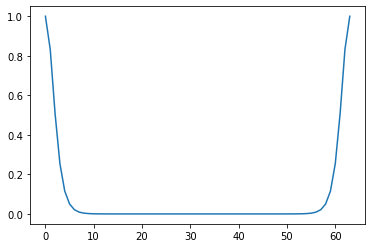

0.196
3


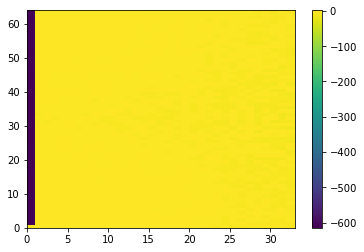

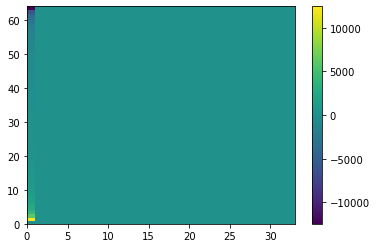

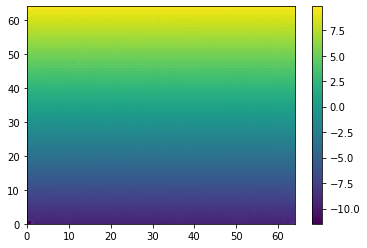

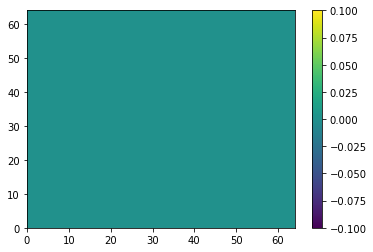

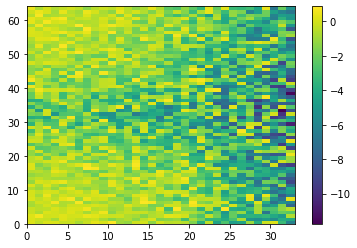

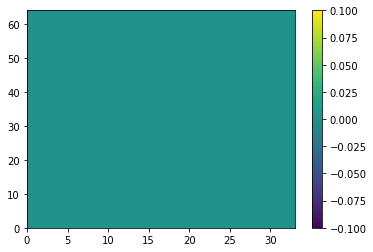

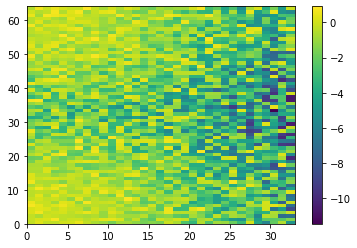

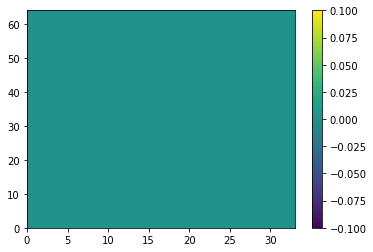

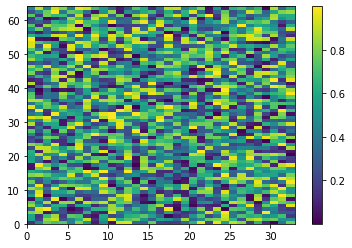

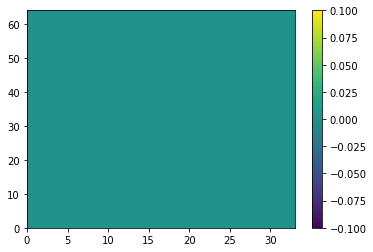

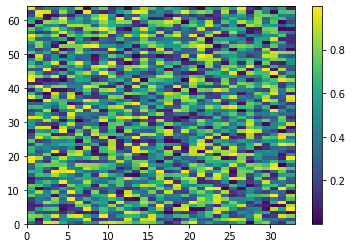

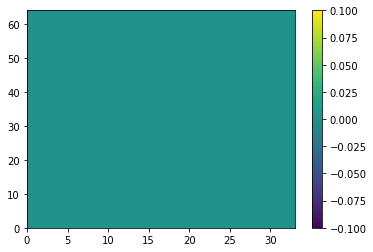

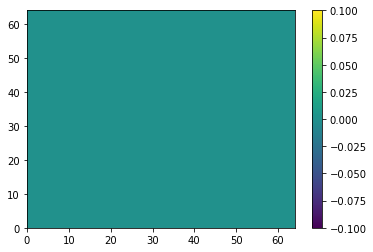

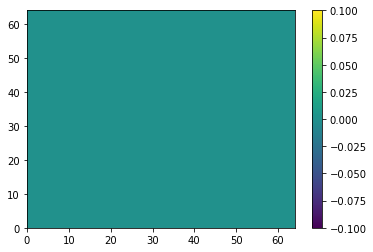

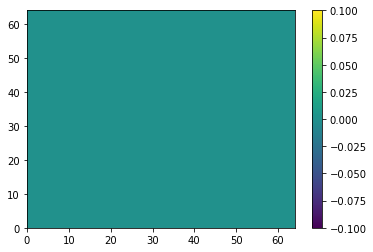

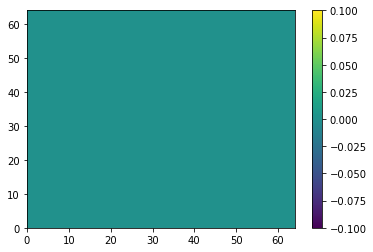

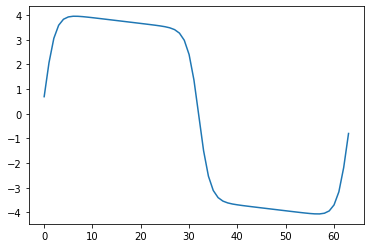

In [114]:
print(tau_d)
print(tau_f)
plt.plot(sponge.real)
plt.show()
print(beta)
print(opt)

plt.pcolor(qc_1[0,:,:].real)
plt.colorbar()
plt.show()

plt.pcolor(qc_1[0,:,:].imag)
plt.colorbar()
plt.show()

plt.pcolor(q_1[0,:,:].real)
plt.colorbar()
plt.show()

plt.pcolor(q_1[0,:,:].imag)
plt.colorbar()
plt.show()


plt.pcolor(vorc_1[0,:,:].real)
plt.colorbar()
plt.show()

plt.pcolor(vorc_1[0,:,:].imag)
plt.colorbar()
plt.show()

plt.pcolor(vorc_2[0,:,:].real)
plt.colorbar()
plt.show()

plt.pcolor(vorc_2[0,:,:].imag)
plt.colorbar()
plt.show()

plt.pcolor(psic_1[0,:,:].real)
plt.colorbar()
plt.show()

plt.pcolor(psic_1[0,:,:].imag)
plt.colorbar()
plt.show()

plt.pcolor(psic_2[0,:,:].real)
plt.colorbar()
plt.show()

plt.pcolor(psic_2[0,:,:].imag)
plt.colorbar()
plt.show()

plt.pcolor(psi_1[0,:,:].real)
plt.colorbar()
plt.show()

plt.pcolor(psi_1[0,:,:].imag)
plt.colorbar()
plt.show()

plt.pcolor(psi_2[0,:,:].real)
plt.colorbar()
plt.show()

plt.pcolor(psi_2[0,:,:].imag)
plt.colorbar()
plt.show()


plt.plot(psi_R)
plt.show()

In [96]:
print("Timestep:", 0)

forc1 = np.zeros( ( N2, N ) )
forc2 = np.zeros( ( N2, N ) )
cforc1 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)
cforc2 = np.zeros( ( N2, N // 2 + 1  ) ).astype(complex)

nl1 = np.zeros( ( N2, N // 2 + 1  ) ).astype(complex)
nl2 = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)

#mforc = np.zeros( ( N2, N // 2 + 1 ) ).astype(complex)

F = exponential_cutoff( psic_1[0], np.log(1. + 400. * np.pi / float(N) ), 6, 7 )

norm = np.zeros( int(ts / 10) )
norm[0] = np.linalg.norm( psic_1[1] + psic_2[1] )

u = np.zeros( ( ( int((ts - lim) / 10), 2, N2 ) ) )
#v = np.zeros( ( ( ( int((ts - lim) / 10), 2, N2, N ) ) ) )
#z_emfs = np.zeros( ( ( 1000, 2, N2 ) ) )

Timestep: 0


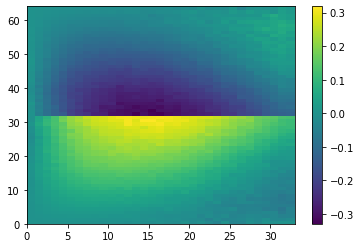

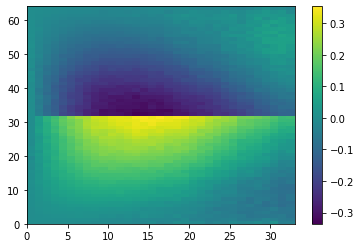

/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/will/anaconda2/envs/Dawson/lib/python3.6/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


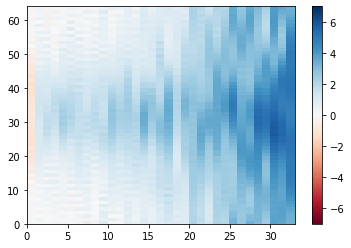

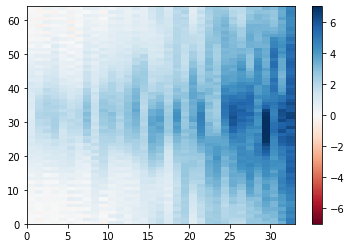

..pulling breaks...


In [139]:
#######################################################
# %% Initial conditions:

psic_1[0] = [ [ random() for i in range(N // 2 + 1 ) ] for j in range(N2) ] # wn space
psic_2[0] = [ [ random() for i in range(N // 2 + 1 ) ] for j in range(N2) ]

#Transfer values:
psic_1[ 1 , : , : ] = psic_1[ 0 , : , : ]
psic_2[ 1 , : , : ] = psic_2[ 0 , : , : ]

#Calculate initial PV
# %%

for i in range( 2 ):
	vorc_1[i], vorc_2[i] = ptq(ll, kk, psic_1[i], psic_2[i]) # in and outputs in wave number space

q_1[0:2, :,: ] = fft.irfft2( vorc_1[0:2,:,:], workers=nworker ) + beta * y[:, np.newaxis] # to real
q_2[0:2, :,: ] = fft.irfft2( vorc_2[0:2,:,:], workers=nworker ) + beta * y[:, np.newaxis] # to real

qc_1[0:2,:,:] = fft.rfft2( q_1[0:2,:,:] , workers=nworker )  # to imag
qc_2[0:2,:,:] = fft.rfft2( q_2[0:2,:,:] , workers=nworker )  # to imag



###########################
psi1 = fft.irfft2( psic_1[1] , workers=nworker )
psi2 = fft.irfft2( psic_2[1] , workers=nworker )


for i in range( 1, 20000):
#     print('starting:',i)
    start = time.time()

    #x 12ms
    #timeit
    # if i % 100 == 0:
    # 	print("Timestep:", i, ' / ', ts)
    # 	# plt.contourf(u[:, 0] )
    # 	# plt.show()


    if opt > 1:
        #NL terms -J(psi, qc) - beta * v
        nl1[:, :] = -nlterm( kk, ll, psic_1[1, :, :], vorc_1[1, :, :]) - beta * 1.j * np.expand_dims(kk, 0) * psic_1[1, :, :]
        nl2[:, :] = -nlterm( kk, ll, psic_2[1, :, :], vorc_2[1, :, :]) - beta * 1.j * np.expand_dims(kk, 0) * psic_2[1, :, :]
        
        plt.pcolor(nl1.real)
        plt.colorbar()
        plt.show()
        plt.pcolor(nl2.real)
        plt.colorbar()
        plt.show()

    if opt != 2:
        #Linear terms
        #Relax interface
        forc1[:, :] = (psi_1[1] - psi_2[1] - psi_R[:, np.newaxis]) / tau_d
        forc2[:, :] = -(psi_1[1] - psi_2[1] - psi_R[:, np.newaxis]) / tau_d

        #Sponge
        forc1[:, :] -= sponge[:, np.newaxis] * (q_1[1] - np.mean( q_1[1], axis = 1)[:, np.newaxis] )
        forc2[:, :] -= sponge[:, np.newaxis] * (q_2[1] - np.mean( q_2[1], axis = 1)[:, np.newaxis] )

        #Convert to spectral space + add friction
        cforc1 = fft.rfft2( forc1  , workers =nworker)
        cforc2 = fft.rfft2( forc2  , workers =nworker) + ( np.expand_dims(kk, 0) ** 2  + np.expand_dims(ll, 1) ** 2 ) * psic_2[1] / tau_f
        
        plt.pcolor(cforc1.real,cmap='RdBu',vmin=-7,vmax=7)
        plt.colorbar()
        plt.show()
        plt.pcolor(cforc2.real,cmap='RdBu',vmin=-7,vmax=7)
        plt.colorbar()
        plt.show()
        
    rhs1 = nl1[:] + cforc1[:]
    rhs2 = nl2[:] + cforc2[:]
    
    
    print('..pulling breaks...')
    break
    print('i didnt break')

    if i == 1:
        #Forward step
        qc_1[2, :] = fs(qc_1[1, :, :], rhs1[:], dt, nu, kk, ll)
        qc_2[2, :] = fs(qc_2[1, :, :], rhs2[:], dt, nu, kk, ll)

    else:
        #Leapfrog step
        qc_1[2, :, :] = lf(qc_1[0, :, :], rhs1[:], dt, nu, kk, ll)
        qc_2[2, :, :] = lf(qc_2[0, :, :], rhs2[:], dt, nu, kk, ll)
    #x 1.3ms
    #timeit
    q_1[1] = fft.irfft2( qc_1[2]  , workers =nworker)
    q_2[1] = fft.irfft2( qc_2[2]  , workers =nworker)

    #Subtract off beta and invert
    vorc_1[1] = fft.rfft2( q_1[1] - beta * y[:, np.newaxis] , workers =nworker)
    vorc_2[1] = fft.rfft2( q_2[1] - beta * y[:, np.newaxis] , workers =nworker)
    psic_1[1], psic_2[1] = qtpM(kk,ll, vorc_1[1], vorc_2[1] )
    psi_1[1] = fft.irfft2( psic_1[1]  , workers =nworker)
    psi_2[1] = fft.irfft2( psic_2[1]  , workers =nworker)
        
    if i > 1:
        #Leapfrog filter
        qc_1[1, :] = filt( qc_1[1, :], qc_1[0, :], qc_1[2, :], g)
        qc_2[1, :] = filt( qc_2[1, :], qc_2[0, :], qc_2[2, :], g)
        
    q_1[0:2] = fft.irfft2( qc_1[1:]  , workers =nworker)
    q_2[0:2] = fft.irfft2( qc_2[1:]  , workers =nworker)

    #Subtract off beta and invert
    vorc_1[0:2] = fft.rfft2( q_1[0:2] - beta * y[:, np.newaxis] , workers =nworker)
    vorc_2[0:2] = fft.rfft2( q_2[0:2] - beta * y[:, np.newaxis] , workers =nworker)
    psic_1[0:2], psic_2[0:2] = qtp_3d(kk, ll, vorc_1[0:2], vorc_2[0:2] )

    psi_1[0:2] = fft.irfft2( psic_1[0:2] , workers =nworker)
    psi_2[0:2] = fft.irfft2( psic_2[0:2] , workers =nworker)


    #Transfer values:
    qc_1[0:2, :, :] = qc_1[1:, :, :]
    qc_2[0:2, :, :] = qc_2[1:, :, :]
    
    if i %1000 == 0: 
        print(i,np.max(q_2[1,:,:]))
        plt.contourf(q_2[0,:,:],20,cmap='RdBu',vmin=-8,vmax=8)
        plt.colorbar()
        plt.show()

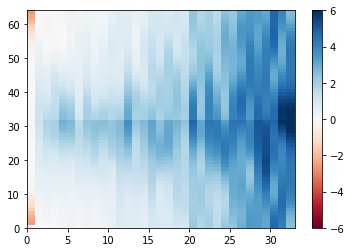

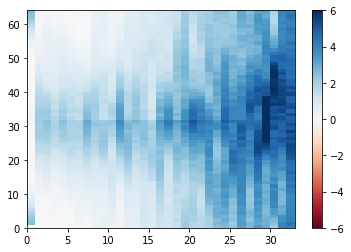

In [123]:
plt.pcolor(rhs1.real,vmin=-6,vmax=6,cmap='RdBu')
plt.colorbar()
plt.show()

plt.pcolor(rhs2.real,vmin=-6,vmax=6,cmap='RdBu')
plt.colorbar()
plt.show()

100.0
15.0


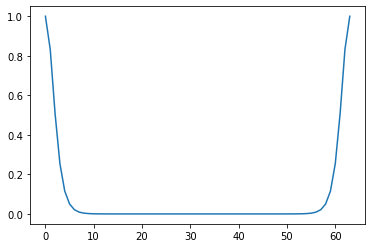

0.196
3


In [94]:
print(tau_d)
print(tau_f)
plt.plot(sponge.real)
plt.show()
print(beta)
print(opt)

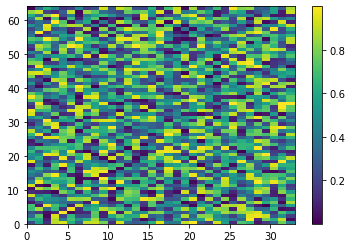

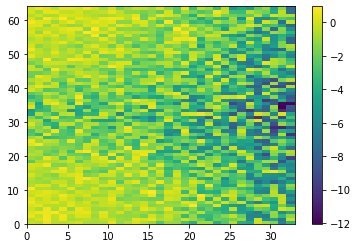

In [132]:
plt.pcolor(psic_1[1, :, :].real) 
plt.colorbar()
plt.show()
vorc_1[1, :, :]
plt.pcolor(vorc_1[1, :, :].real) 
plt.colorbar()
plt.show()

In [ ]:
psic_2[1, :, :], vorc_2[1, :, :]